# Basics about Xarray

#  Xarray 
(https://docs.xarray.dev/en/stable/generated/xarray.Dataset.keys.html)


- Reading netCDF file into an xarray dataset

- Subsetting a dataset by time and space

- Plotting (https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#cartopy-projections)

- Calculating metrics, e.g. mean, maximum,STD, corr....etc

- Grouping and resampling in time

- Masking

- Opening multiple files as a single dataset

- Saving our output as netCDF

About the python package [xarray](http://xarray.pydata.org/en/stable/):

> Xarray introduces **labels in the form of dimensions, coordinates and attributes** on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures.

> Xarray was inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with dask for parallel computing.




# Reading data and associated metadata from a netCDF file into an xarray dataset

# Opening a dataset

An xarray [dataset](http://xarray.pydata.org/en/stable/data-structures.html#dataset) is a container for data and it's associated metadata, including labelled coordinates.

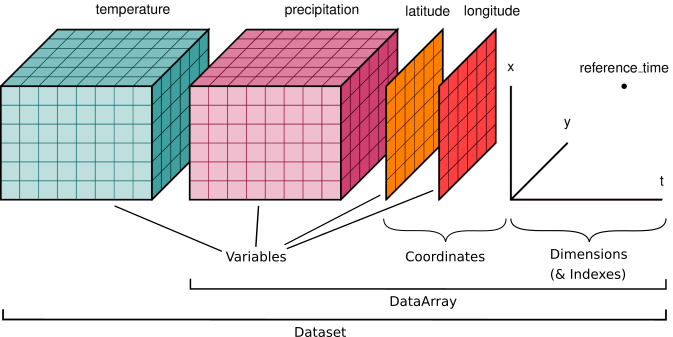

> First step, import the xarray package

In [75]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

When opening a netCDF file, the file metadata is read and stored as an `xarray.DataSet`. In this case the file is accessed via an [OpenDap](https://www.opendap.org) server so it is universally accessible. The equivalent command if the netCDF file was saved in the same directory as the notebook is shown commented out for reference

In [ ]:
# open with OpenDap URL
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables=['time_bnds'])
#ds = ds.sel(time=slice('1960', '2018')).load()     #data b/w 1960 to 2018
ds
#ds = xr.open_dataset('/run/media/nagaraju/DATA_Drive/waveactivity-flex/2020-HadISST_sst.nc')
#ds = xr.open_dataset('2020-HadISST_sst.nc')

There are four sections to note: `Dimensions`, `Coordinates`, `Data variables` and `Attributes`.

`Dimensions` give the size of each named dimension. This is a CF-compliant (http://cfconventions.org) dataset, which means any variable which has the same name as a dimension is assumed to be a coordinate. There are other metadata which may be used to denote a coordinate. In this case `xarray` signifies coordinates associated with variables with `*`.

`Data variables` lists all the variables that are not coordinates. In this case three of them are bounds variables, definining the beginning and end values for the three coordinates. The only true data variables is `tas`.

# Accessing the data

The `open_dataset` command only reads the metadata from the netCDF file. It does not attempt to read any data until there is an operation that requires this.

The `xarray.DataSet` object has a number of methods for accessing the coordinates, attributes and data. The data variables are saved in a `dict`-like structure, `ds.data_vars`:

In [ ]:
ds.data_vars

It is possible to loop over the data variables just by looping over the dataset, which returns each variable name in turn: If you have many data variables (ex: model data)

In [ ]:
for varname in ds:
    print(varname)

An individual variable can be accessed using it's name, either as a `dict` like key

In [ ]:
ds['sst']

#ds.sst  ,For ease of use xarray also provides access to data variables as a python attribute


# Subsetting a dataset by time and space (Slicing and Dicing)

In [ ]:
sst_data = ds.sst
sst_data

In [ ]:
sst_data=sst_data[:,::-1,:]   # latitude changing south to north 
sst_data

In [ ]:
sst_data.shape

> By selecting just the first time index it has created a DataArray with no time dimension, but time is still a coordinate not associated with any variable, as indicated by no longer having * beside it. It now only has one value: the value of the first time index. The index selection above is equivalent to using **isel**.

In [ ]:
#sst_data[0,:]
sst_data.isel(time=0)


**The power of xarray comes with the close association of data with coordinates**. So it is possible to use the equivalent **`.sel`** operator but with coordinate values. For example, to select an area that includes the Indian Ocean and Pacific Ocean use **`slice`** to indicate the **range of latitude and longitude values required and pass as key/value pairs to `sel`**.  **`slice`** will include coordinate values less than **or equal** to the upper bound, not like `range` in basic python that excludes the upper bound.

In [ ]:
sst_data.sel(lon=slice(20,180),lat=slice(-25,45))

Operators can be chained, so multiple operations can be peformed sequentially. For example, to select the above area and the first time index

In [ ]:
sst_data.isel(time=0).sel(lon=slice(20,180), lat=slice(-25,45))

In this case it is convenient to use **isel** to select the time, rather than specifying a date, but it is also possible to specify the date explicitly using **sel**

In [ ]:
sst_data.sel(time='2020-06', lon =slice(20,180), lat=slice(-25,45))

**The **slice** operator selects values between an upper and lower bound**. If a single coordinate value is required when using **sel** it must either correspond to an **exact** value in the coordinate array, or the **method** argument specified to tell xarray how to choose a value.

In [ ]:
sst_data.sel(lat=-27.47, lon=153.03, method='nearest')

# Plotting with xarray

The xarray library has an inbuilt `plot` function that is a thin wrapper around the [matplotlib library](https://matplotlib.org).

The [documentation of the xarray plot function is excellent](http://xarray.pydata.org/en/stable/plotting.html). Read it for an in-depth explanation of the power of the xarray plotting functionality. This notebook covers just enough to get started and make use of plots in subsequent tutorials.

As xarray dataarrays contain all the associated metadata and coordinates for the data, it can create informative plots with very little effort.

In [ ]:
sst_data.isel(time=0).plot(size=6)

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.gridlines()
sst_data.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(),
         vmin=2, vmax=30, cbar_kwargs={'shrink': 0.6})

In [ ]:
projections = [ccrs.PlateCarree(),
               ccrs.Robinson(),
               ccrs.Mercator(),
               ccrs.Orthographic(),
               ccrs.InterruptedGoodeHomolosine()
              ]


for proj in projections:
    plt.figure()
    ax = plt.axes(projection=proj)
    ax.stock_img()
    ax.coastlines()
    ax.set_title(f'{type(proj)}')

In [ ]:
sst = ds.sst.sel(time='2000-01-01')
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
sst.plot(ax=ax, transform=ccrs.PlateCarree(),
         vmin=2, vmax=30, cbar_kwargs={'shrink': 0.4})

In [ ]:
# if there is an missing values for example
test_data = xr.open_dataset('2020-HadISST_sst.nc')
#test_dat
#test_data.sst[0,:].plot()
test_data = test_data.sst.where(test_data.sst!= -1000.) #Remove -1000 values
test_data[0,:].plot()

In [ ]:
sst_data.isel(time=0).plot(size=6,robust=True)

Operator chaining means it is possible to have multiple selection operators and add .plot to the end to visualise the result

In [ ]:
sst_data.isel(time=0).sel(lon=slice(40,180), lat=slice(-20,40)).plot(size=6,cmap='bwr')

xarray will automatically guess the type of plot based on the dimensionality of the data being plotted. If passed too many dimensions xarray will default to displaying a histogram

In [ ]:
sst_data.sel(time=slice('2020-01','2020-12'), lon=slice(40,180), lat=slice(-20,40)).plot(size=6)

Reduce the dimensionality enough and it will plot a line. For example, a time series of near surface temperatures in Brisbane (Note: this is selecting a single point, so **sel** requires either an exact location that exists in the data, or to specify method argument to tell it how to choose a location from the data)

In [ ]:
sst_data.sel(time=slice('2020-01','2020-12')).sel(lat=-27.47, lon=153.03, method='nearest').plot(size=6)

# Xarray calculations

Xarray Interpolation, Groupby, Resample, Rolling, and Coarsen

xarray was developed as an n-dimensional extension of [pandas](https://pandas.pydata.org), a very powerful data analysis library designed primarily for tabular data and time series analysis.

As a result xarray can utilise much of the time series manipulation power of pandas. The relevant xarray documentation is contained in the [GroupBy](http://xarray.pydata.org/en/stable/groupby.html) and [Time series data](http://xarray.pydata.org/en/stable/time-series.html) sections.



In [ ]:
sst_data[0,:].plot(vmin=0, vmax=30)

Note that xarray correctly parsed the time index, resulting in a Pandas datetime index on the time dimension.

In [ ]:
sst_data.time

In [ ]:
sst_data.sel(lon=300, lat=10).plot()

In [64]:
ds.sst.groupby?

# Split Step

> The most important argument is group: this defines the unique values we will us to “split” the data for grouped analysis. We can pass either a DataArray or a name of a variable in the dataset. Lets first use a DataArray. Just like with Pandas, we can use the time indexe to extract specific components of dates and times. Xarray uses a special syntax for this **.dt**, called the **DatetimeAccessor**.

In [ ]:
sst_data.time.dt

In [ ]:
sst_data.time.dt.month

# We can use these arrays in a groupby operation:

In [ ]:
gb = sst_data.groupby(sst_data.time.dt.month)
gb

In [ ]:
#Like Pandas, xarray’s groupby object has many built-in aggregation operations (e.g. mean, min, max, std, etc):
# this does the same thing as the previous cell
sst_mm = gb.mean(dim='time')   # nothing but monthly climatology
sst_mm

In [ ]:
sst_mm.sel(lon=300, lat=10).plot()

# Zonal Mean Climatolgoy

In [ ]:
sst_mm.mean(dim='lon').transpose().plot.contourf(levels=10, vmin=-2, vmax=30)

# Difference between January and July Climatology

In [ ]:
(sst_mm.sel(month=1) - sst_mm.sel(month=7)).plot(vmax=10) 

Now we want to remove this **climatology** from the dataset, to examine the residual, called the anomaly, which is the interesting part from a climate perspective. Removing the seasonal climatology is a perfect example of a transformation: it operates over a group, but doesn’t change the size of the dataset. Here is one way to code it.

In [ ]:
#  with group by 
sst_clim=ds.sst.groupby("time.month").mean("time")
sst_anomalies = ds.sst.groupby("time.month") - sst_clim
sst_anomalies

In [163]:
#Calculate Oceanic Niño Index
sst_anom_nino34 = sst_anomalies.sel(lat=slice(5, -5), lon=slice(190, 240))
sst_anom_nino34_mean = sst_anom_nino34.mean(dim=('lon', 'lat'))
oni = sst_anom_nino34_mean.rolling(time=3, center=True).mean()

In [ ]:
oni.plot()
plt.grid()
plt.ylabel('Anomaly (dec. C)');
plt.axhline(0, color='r')

In [ ]:
# Spatial Correlation

r_map=xr.corr(oni,sst_anomalies,dim='time')
r_map.plot(robust=True)

In [ ]:
elnino=oni.where(oni>=1)
lanina=oni.where(oni>=1)


#positive_oni = ((oni>0.5).rolling(time=3, center=True).sum()==3)
#negative_oni = ((oni<0.5).rolling(time=3, center=True).sum()==3)


In [ ]:
elnino

In [ ]:
sst_anom.where(oni>=1).mean(dim='time').plot()
plt.title('SST Anomaly - Positive Niño3.4');

In [ ]:
sst_anom.where(oni<=-1).mean(dim='time').plot()
plt.title('SST Anomaly - Negative Niño3.4');

In [ ]:
sst_anom.sel(lon=300, lat=10).plot()

- Difference between Jan. 1 2018 and Jan. 1 1960

In [ ]:
(ds_anom.sel(time='2018-01-01') - ds_anom.sel(time='1960-01-01')).plot()

# Resample
- Resample in xarray is nearly identical to Pandas. It can be applied only to **time-index** dimensions. Here we compute the five-year mean. It is effectively a group-by operation, and uses the same basic syntax. Note that resampling changes the length of the the output arrays.

In [ ]:
ds_anom_resample = ds_anom.resample(time='5Y').mean(dim='time')
ds_anom_resample

In [ ]:
ds_anom.sel(lon=300, lat=10).plot()
ds_anom_resample.sel(lon=300, lat=10).plot(marker='o')

In [ ]:
(ds_anom_resample.sel(time='2014-12-31') -ds_anom_resample.sel(time='2024-12-31')).plot()

# Rolling
- Rolling does not change the length of the arrays. Instead, it allows a moving window to be applied to the data at each point.

In [ ]:
ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()
ds_anom_rolling

In [ ]:
ds_anom.sel(lon=300, lat=10).plot(label='monthly anom')
ds_anom_resample.sel(lon=300, lat=10).plot(marker='o', label='5 year resample')
ds_anom_rolling.sel(lon=300, lat=10).plot(label='12 month rolling mean', color='k')
plt.legend()

# Coarsen
- coarsen is **a simple way to reduce the size of your data along one or more axes**. It is very **similar to resample when operating on time dimensions**; the key differnce is that coarsen only operates on fixed blocks of data, irrespective of the coordinate values, while resample actually looks at the coordinates to figure out, e.g. what month a particular data point is in.

- For regularly-spaced monthly data beginning in January, the following should be equivalent to annual resampling. However, results would different for irregularly-spaced data.

In [ ]:
ds_coarse = ds_anom.coarsen(lon=4, lat=4, boundary='pad').mean()
ds_coarse.isel(time=0).plot(vmin=-2, vmax=2, figsize=(12, 5), edgecolor='k')

In [ ]:
ds_coarse

In [ ]:
ds.sst.groupby('time.season').mean(dim='time').plot(col='season', col_wrap=2)

# Masking

xarray supports masking usimg the `.where` operator. This can be used to mask a `DataArray` by itself, by it's coordinates, or by another `DataArray` with matching coordinates.

As a trivial first example mask tas with itself. For clarity a variable, sst0, is defined, It is the first time slice of sst0. Then sst is used to mask itself and only plot temperatures between 27C and 29C.

In [ ]:
sst0 = ds.sst.isel(time=0)
sst0.where(sst0>25).where(sst0<29).plot(size=6,cmap='bwr',robust=True);

The mask can be applied to any time in the `sst` `DataArray`, or even the whole array. xarray will automatically broadcast along a missing dimension. To show how it works `sst0` is used as the mask criteria for a different time point in `sst`. The colourbar shows the plotted data contains values outside the range of the mask, as the mask is based on criteria from a different time point.

In [ ]:
ds.sst.where(sst0>25).where(sst0<29).isel(time=300).plot(size=6)

# Opening multifile datasets

In many cases large datasets are spead over multiple files, so no individual file becomes too large, and operating on a subset of the data is easier without having to read the whole dataset

xarray can open multiple files as a single xarray `Dataset` with the `open_mfdataset` command. Pass it either a list of files to open, or a wildcard string that matches the desired files. 

This is useful as it can skip wasteful steps of creating intermediate datasets which are aggregations of existing data. Just load it all up and select out what is required.

In [ ]:
files = ['data1.nc', 
        'data2.nc',
        'dat2.nc']
prefix = 'path of you data_'
data_files = [prefix+file for file in files]
data_files

In [212]:
base_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995'

files = [f'{base_url}.{year}.nc' for year in range(1948, 2019)]
#files
ds = xr.open_mfdataset(files)
ds

<xarray.Dataset>
Dimensions:  (lon: 144, time: 103732, lat: 73)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 ... 2018-12-31T18:00:00
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(1464, 73, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (1948)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    history:                         created 99/05/11 by Hoop (netCDF2.3)\nCo...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
ds.air[0,:].plot()

# Saving data to netCDF

The most common usage pattern for saving data is one where data is read from a netCDF file.


In [ ]:
data.to_netcdf('tas.nc')

In [ ]:
dat.to_netcdf('test.nc', encoding=tas.encoding.update({'zlib': True, 'complevel': 4}))

In [216]:




#Description: Empirical Orthogonal Functions (EOF).
 


import numpy as np
import xarray as xr
import proplot as plot
import matplotlib.pyplot as plt
from esmtools.stats import*
from eofs.xarray import Eof


# --- read netcdf file
dset = xr.open_dataset('/home/nagaraju/Downloads/asstdt_pacific_123.nc')

# --- select djf months
sst = dset['sst'].sel(time=np.in1d(dset['time.month'], [1, 2, 12]))

# --- square-root of cosine of latitude weights
coslat = np.cos(np.deg2rad(sst.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
# --- eof solver
solver = Eof(sst, weights=wgts)
# --- eof results
eofs = solver.eofsAsCorrelation(neofs=2)
pcs = solver.pcs(npcs=2, pcscaling=1)
variance_fractions = solver.varianceFraction()
north_test = solver.northTest(vfscaled=True)


# --- spatial patterns
fig, ax = plot.subplots(axwidth=5, nrows=2, tight=True, proj='pcarree',
                        proj_kw={'lon_0': 180})
# --- format options
ax.format(land=False, coast=True, innerborders=True, borders=True,
          large='15px', labels=False,
          latlim=(31, -31), lonlim=(119, 291),
          geogridlinewidth=0,
          abcloc='ul')
# a) first EOF mode
map1 = ax[0].contourf(dset['lon'], dset['lat'], eofs[0, :, :],
                      levels=np.arange(-0.5, 0.6, 0.1), cmap='Div', extend='both')

# b) second EOF mode
map2 = ax[1].contourf(dset['lon'], dset['lat'], eofs[1, :, :],
                      levels=np.arange(-0.5, 0.6, 0.1), cmap='Div', extend='both')

ax[1].colorbar(map2, loc='b', length=0.9)

plt.show()


# --- principal components
fig, ax = plot.subplots(figsize=(10, 5), nrows=2, ncols=1,
                        tight=True, sharex=False, sharey=False)

ax[0].plot(np.arange(len(variance_fractions[0:10])),
           variance_fractions[0:10] * 100,)
ax[0].plot(np.arange(len(variance_fractions[0:10])),
           variance_fractions[0:10] * 100, 'ro')

ax[1].plot(pcs['time'], pcs[:, 0], color='red', label='PC1')
ax[1].plot(pcs['time'], pcs[:, 1], color='blue', label='PC2')

plt.legend()

plt.show()

/home/nagaraju/anaconda3/lib/python3.8/site-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


ModuleNotFoundError: No module named 'esmtools'

In [ ]:
conda install -c conda-forge esmtools